# CCE Moorings - Data Processing 

**Purpose**: Code for processing CCE mooring observations. CCE mooring QC'd data can be found on the OCean Time-series Group [website](https://mooring.ucsd.edu/cce/) and through the thredds server ([CCE1](https://dods.ndbc.noaa.gov/thredds/catalog/oceansites/DATA/CCE1/catalog.html) and [CCE2](https://dods.ndbc.noaa.gov/thredds/catalog/oceansites/DATA/CCE2/catalog.html)). The real-time CCE3 data may be found [here](https://mooring.ucsd.edu/cce3/cce3_01/csv/).

**Notes**: The ADCP depths are less than a meter from each other between deployments so nearest neighbor binning is a valid approach because the velocity does not change on the other of less than a meter.

**Luke Colosi | lcolosi@ucsd.edu**

Force matplotlib plots to display directly within the output cell of the notebook: 

In [1]:
%matplotlib inline


Import python libraries


In [2]:
#--- Build-in Python Functions ---# 
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date
from datetime import datetime, timedelta
import pandas as pd
import cartopy.crs as ccrs
import sys
import os
import matplotlib 
from geopy.distance import geodesic
import cftime
import matplotlib.dates as mdates
import gsw
import matplotlib as cm
import cmocean
import glob 
from scipy.interpolate import interp1d
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyproj import Proj, Transformer

# Set path to access python functions
sys.path.append('/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/tools/')

#--- Luke's Python Functions ---# 

Set data analysis parameters

In [3]:
# Set processing parameters
option_plot          = 0      # Specifies if supplementary plots are plotted
option_mooring       = 'CCE2' # Specifies which mooring will analyzed. 
option_obs           = 'ADCP'  # Specifies the observational instrumentation to process. Options include: 'CTD', 'CHL', 'ADCP'
option_plot          = True 

# Set time and space parameters
T = 1                                            # Specifies the duration of the bin averaging (units: hours)
isobath    = -2000                               # Specifies isobath depth contour. Units: m
start_time = datetime(2014, 1, 1, 0, 0, 0)       # Specifies the start time of the event period datetime(2016, 1, 1, 0, 0, 0) 
end_time = datetime(2015, 12, 31, 23, 59, 59)    # Specifies the end time of the event period datetime(2017, 12, 31, 23, 59, 59)
event_time_bnds = [start_time, end_time]         # Specifies the event period
lat_bnds   = [33, 35]                      # Specifies the latitude bounds for the region to analyze
lon_bnds   = [-123 % 360, -120 % 360]      # Specifies the longitude bounds for the region to analyze

# Set path to project directory
PATH = "/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling"
PATH_bathy  = '/Users/lukecolosi/Desktop/projects/graduate_research/Gille_lab/AirSeaCoupling/data/bathymetry/'

# Set plotting parameters 
fontsize = 14

Read in bathymetry data

In [4]:
# Load bathymetry data 
filename = PATH_bathy + "topo_25.1.nc"
ds_bathy = xr.open_dataset(filename, engine="netcdf4")

# Extract data variables
lon_b = ds_bathy["lon"]  # Longitude
lat_b = ds_bathy["lat"]  # Latitude
bathy = ds_bathy["z"]    # Elevation/Bathymetry

# Convert convesion of longitude (neg from the prime meridian to positive definite wrapping around the earth)
lon_n = lon_b % 360

# Set max and min values 
lon_min = lon_bnds[0]
lon_max = lon_bnds[1]
lat_min = lat_bnds[0]
lat_max = lat_bnds[1]

# Extract data from bathymetry 
lon_grid = lon_n[(lon_n >= lon_min) & (lon_n <= lon_max)]
lat_grid = lat_b[(lat_b >= lat_min) & (lat_b <= lat_max)]
bathy_grid   = bathy[(lat_b >= lat_min) & (lat_b <= lat_max),(lon_n >= lon_min) & (lon_n <= lon_max)]

Load and process CCE data for each deployment 

In [6]:
# Set root path
ROOT = "/data/CCE/" + option_mooring + "/" + option_obs + "/"

# Set filenames and counter
filenames = sorted(glob.glob(PATH + ROOT + "OS_" + option_mooring + "_*_D_" + option_obs + ".nc"))
cn = 0

# Set the depths for CCE1 and CCE2 
if option_mooring == 'CCE1': 

    #--- CTD ---# 
    if option_obs == 'CTD':
        depth = np.array([9.0, 19.0, 29.0, 39.0, 60.0, 75.0, 150.0, 300.0, 524.0, 752.0, 1002.0, 2215.0, 3969.0])
    #--- ADCP ---# 
    elif option_obs == 'ADCP': 
        depth = np.array([ 14.7,  24.7,  34.7,  44.7,  54.7,  64.7,  74.7,  84.7,  94.7, 104.7, 114.7, 124.7,
                           134.7, 144.7, 154.7, 164.7, 174.7, 184.7, 194.7, 204.7, 214.7, 224.7, 234.7, 244.7,
                           254.7, 264.7, 274.7, 284.7, 294.7, 304.7, 314.7, 324.7, 334.7, 344.7, 354.7, 364.7,
                           374.7, 384.7, 394.7, 404.7, 414.7, 424.7, 434.7, 444.7, 454.7, 464.7, 474.7, 484.7,
                           494.7, 504.7, 514.7, 524.7, 534.7, 544.7, 554.7])
        
elif option_mooring == 'CCE2':
    #--- CTD ---# 
    if option_obs == 'CTD':
        depth = np.array([6.1, 14.1, 25.3, 44.5, 74.5])
    #--- ADCP ---# 
    elif option_obs == 'ADCP': 
        depth = np.array([ 14.7,  24.7,  34.7,  44.7,  54.7,  64.7,  74.7,  84.7,  94.7, 104.7, 114.7, 124.7,
                           134.7, 144.7, 154.7, 164.7, 174.7, 184.7, 194.7, 204.7, 214.7, 224.7, 234.7, 244.7,
                           254.7, 264.7, 274.7, 284.7, 294.7, 304.7, 314.7, 324.7, 334.7, 344.7, 354.7, 364.7,
                           374.7, 384.7, 394.7, 404.7, 414.7, 424.7, 434.7, 444.7, 454.7, 464.7, 474.7, 484.7,
                           494.7, 504.7, 514.7, 524.7, 534.7, 544.7, 554.7])

# Initialize variables:

#--- CTD ---#
if option_obs == 'CTD':
    pres_ls = []
    sal_ls  = []
    temp_ls = []
    time    = []

#--- ADCP ---#
if option_obs == 'ADCP':
    ucur_ls = []
    vcur_ls = []
    time    = []

# Loop through filenames
for f in filenames:

    # ----------------------------------------------------------------
    # STEP 1 - Read in data from netcdf file
    # ----------------------------------------------------------------

    # Set nc variable:
    nc = Dataset(f, "r")

    # Extract data variables
    itime  =  num2date(nc.variables['TIME'][:], nc.variables['TIME'].units)
    idepth = nc.variables['DEPTH'][:]

    print(idepth)

    #--- CTD ---#
    if option_obs == 'CTD':
        ipres = nc.variables['PRES'][:]
        isal  = nc.variables['PSAL'][:]
        itemp = nc.variables['TEMP'][:]
        ipres_qc = nc.variables['PRES_QC'][:]
        isal_qc  = nc.variables['PSAL_QC'][:]
        itemp_qc = nc.variables['PRES_QC'][:]

    #--- ADCP ---#
    if option_obs == 'ADCP':
        iucur = nc.variables['UCUR'][:].T  # Transpose variable to match the dimensions organization of the CTD data: (depth,time)
        ivcur = nc.variables['VCUR'][:].T

    if cn == 0: 
        lat  = nc.variables['LATITUDE'][:]
        lon  = nc.variables['LONGITUDE'][:]

    # Remove depths not-consistent between deployments
    if (option_mooring == 'CCE2') & (option_obs == 'CTD'): 

        # Set the depth tolerance
        tol = 0.2

        # Set the maximum depth condition
        max_depth = 100

        # Compute pairwise absolute differences between arr and valid_depths
        diff_matrix = np.abs(idepth[:, None] - depth)

        # Create a mask for values in arr that are within tolerance of any valid depth
        close_mask = np.any(diff_matrix < tol, axis=1)
    
        # Create a mask for values in arr that shallower than the maximum depth 
        shallow_mask = idepth < max_depth
        keep_mask = close_mask | shallow_mask

        # Filter depths
        idepth = idepth[keep_mask]

    # ----------------------------------------------------------------
    # STEP 2 - Extract data from specified time period
    # ----------------------------------------------------------------

    # Find indicies where data is between time bounds
    idx_time = (itime >= event_time_bnds[0]) & (itime <= event_time_bnds[1]) 

    # Index data
    itime_n  =  itime[idx_time]

    #--- CTD ---#
    if option_obs == 'CTD':
        ipres_n  = ipres[:,idx_time]
        isal_n   = isal[:,idx_time]
        itemp_n  = itemp[:,idx_time]
        ipres_qc_n = ipres_qc[:,idx_time]
        isal_qc_n  = isal_qc[:,idx_time]
        itemp_qc_n = itemp_qc[:,idx_time]

    #--- ADCP ---#
    if option_obs == 'ADCP':
        iucur_n = iucur[:,idx_time]
        ivcur_n = ivcur[:,idx_time]

    # Convert cftime.DatetimeGregorian to Python datetime objects
    itime_dt = np.array([datetime(d.year, d.month, d.day, d.hour, d.minute, d.second) for d in itime_n])

    # ----------------------------------------------------------------
    # STEP 3 - Extract data flagged as good, probably good, nominal, or interpolated (Only for CTD data)
    # ----------------------------------------------------------------

    #--- CTD ---#
    if option_obs == 'CTD':

        # Define valid QC flags (good, nominal, and interpolated)
        valid_flags = [1, 2, 7, 8] 

        # Create masks for invalid data
        mask_pres = ~np.isin(ipres_qc_n, valid_flags)
        mask_sal  = ~np.isin(isal_qc_n,  valid_flags)
        mask_temp = ~np.isin(itemp_qc_n, valid_flags)

        # Create masked arrays
        pres_c = np.ma.masked_where(mask_pres, ipres_n)
        sal_c  = np.ma.masked_where(mask_sal,  isal_n)
        temp_c = np.ma.masked_where(mask_temp, itemp_n)

    #--- ADCP ---#
    if option_obs == 'ADCP':

        # NOTE : Data is already quality controlled

        # Create masked arrays
        ucur_c = np.ma.masked_array(iucur_n, mask=False)
        vcur_c = np.ma.masked_array(ivcur_n, mask=False)

    # ----------------------------------------------------------------
    # STEP 4 - Bin (nearest neighbor) depth onto a regular grid  
    # ----------------------------------------------------------------

    # Set the time dimension 
    n_time = len(itime_n)

    # Initialize the interpolated arrays
    #--- CTD ---#
    if option_obs == 'CTD':
        pres_bin = np.ma.masked_all((len(depth), n_time))
        sal_bin  = np.ma.masked_all((len(depth), n_time))
        temp_bin = np.ma.masked_all((len(depth), n_time))

    #--- ADCP ---#
    if option_obs == 'ADCP':
        ucur_bin = np.ma.masked_all((len(depth), n_time))
        vcur_bin = np.ma.masked_all((len(depth), n_time))

    # Loop through depths
    for i, z_ref in enumerate(depth):

        # Compute the different between ith bin depth
        diffs = np.abs(idepth - z_ref)

        # Find the index of the smallerst difference
        nearest_idx = np.argmin(diffs)

        # Set the depth tolerance (in meters) of the binning (CAREFUL!)
        if z_ref <= 100:    # Upper Ocean: high resolution
            tol = 3        
        elif z_ref <= 500:  # Interior Ocean: middle resolution
            tol = 10
        else:               # Deep Ocean: lowest resolution
            tol = 50

        # Determines the ith reference depth has a nearby observed depth that’s close enough to be considered a valid match
        if diffs[nearest_idx] <= tol:

            # Fill binned data with matched profile
            #--- CTD ---#
            if option_obs == 'CTD':
                pres_bin[i, :] = pres_c[nearest_idx, :]
                sal_bin[i, :]  = sal_c[nearest_idx, :]
                temp_bin[i, :] = temp_c[nearest_idx, :]

            #--- ADCP ---#
            if option_obs == 'ADCP':
                ucur_bin[i,:] = ucur_c[nearest_idx, :]
                vcur_bin[i,:] = vcur_c[nearest_idx, :]

    # ----------------------------------------------------------------
    # STEP 5 - Bin average time onto a regular grid
    # ----------------------------------------------------------------

    # Define bin size
    T = 1
    dt = timedelta(hours=T)

    # Create bin edges and centers
    time_start = min(itime_dt)
    time_end   = max(itime_dt)
    time_edges = pd.date_range(start=time_start, end=time_end + dt, freq=f"{T}H").to_pydatetime()
    time_bin   = np.array(time_edges[:-1]) + dt / 2

    # Set dimensions of arrays
    n_depths = len(depth)
    n_bins = len(time_bin)

    #--- CTD ---# 
    if option_obs == 'CTD':

        # Initialize arrays
        pres_b = np.ma.masked_all((n_depths, n_bins))
        sal_b  = np.ma.masked_all((n_depths, n_bins))
        temp_b = np.ma.masked_all((n_depths, n_bins))

        # Loop over depths
        for i in range(n_depths):

            # Create DataFrame with time and variables at the ith depth and convert masked values to nans
            df = pd.DataFrame({
                'time': itime_dt,
                'pres': pres_bin[i, :].filled(np.nan), 
                'sal' : sal_bin[i, :].filled(np.nan), 
                'temp': temp_bin[i, :].filled(np.nan)
            })

            # Assign each data point to a bin
            df['bin'] = pd.cut(df['time'], bins=time_edges, labels=time_bin, include_lowest=True)

            # Compute bin-averaged data and water depth
            grouped = df.groupby('bin',observed=False).agg(
                mean_pres = ('pres', 'mean'),
                mean_sal  = ('sal', 'mean'),
                mean_temp = ('temp', 'mean') 
            ).reset_index()

            # Align to bin centers
            pres_series = pd.Series(data=grouped['mean_pres'].values, index=grouped['bin'].astype('datetime64[ns]'))
            sal_series  = pd.Series(data=grouped['mean_sal'].values,  index=grouped['bin'].astype('datetime64[ns]'))
            temp_series = pd.Series(data=grouped['mean_temp'].values, index=grouped['bin'].astype('datetime64[ns]'))

            # Fill into output array (align bin centers)
            for j, t in enumerate(time_bin):
                pres_b[i, j] = pres_series.get(t, np.nan)
                sal_b[i, j]  = sal_series.get(t, np.nan)
                temp_b[i, j] = temp_series.get(t, np.nan)

        # Place the data into the 2D arrays and mask NaNs
        pres_ls.append(np.ma.masked_invalid(pres_b))
        sal_ls.append(np.ma.masked_invalid(sal_b))
        temp_ls.append(np.ma.masked_invalid(temp_b))
        time.extend(time_bin)

    #--- ADCP ---# 
    if option_obs == 'ADCP':

        # Initialize arrays
        ucur_b = np.ma.masked_all((n_depths, n_bins))
        vcur_b = np.ma.masked_all((n_depths, n_bins))

            # Loop over depths
        for i in range(n_depths):

            # Create DataFrame with time and variables at the ith depth and convert masked values to nans
            df = pd.DataFrame({
                'time': itime_dt,
                'ucur': ucur_bin[i, :].filled(np.nan), 
                'vcur': vcur_bin[i, :].filled(np.nan), 
            })

            # Assign each data point to a bin
            df['bin'] = pd.cut(df['time'], bins=time_edges, labels=time_bin, include_lowest=True)

            # Compute bin-averaged data and water depth
            grouped = df.groupby('bin',observed=False).agg(
                mean_ucur = ('ucur', 'mean'),
                mean_vcur = ('vcur', 'mean'),
            ).reset_index()

            # Align to bin centers
            ucur_series = pd.Series(data=grouped['mean_ucur'].values, index=grouped['bin'].astype('datetime64[ns]'))
            vcur_series  = pd.Series(data=grouped['mean_vcur'].values,  index=grouped['bin'].astype('datetime64[ns]'))

            # Fill into output array (align bin centers)
            for j, t in enumerate(time_bin):
                ucur_b[i, j] = ucur_series.get(t, np.nan)
                vcur_b[i, j] = vcur_series.get(t, np.nan)

        # Place the data into the 2D arrays and mask NaNs
        ucur_ls.append(np.ma.masked_invalid(ucur_b))
        vcur_ls.append(np.ma.masked_invalid(vcur_b))
        time.extend(time_bin)


#--- CTD ---# 
if option_obs == 'CTD':

    # Concatenate along the first axis
    pres = np.ma.concatenate(pres_ls, axis=1)
    sal = np.ma.concatenate(sal_ls, axis=1)
    temp = np.ma.concatenate(temp_ls, axis=1)

#--- ADCP ---# 
if option_obs == 'ADCP':

    # Concatenate along the first axis
    ucur = np.ma.concatenate(ucur_ls, axis=1)
    vcur = np.ma.concatenate(vcur_ls, axis=1)

# Convert time to a numpy array
time = np.array(time)

# ----------------------------------------------------------------
# STEP 6 - Re-align all time to a uniform hourly grid
# ----------------------------------------------------------------

# Define desired hourly time grid (master grid)
time_start = time.min()
time_end   = time.max()
dt = timedelta(hours=1)
time_hourly = np.array([time_start + i * dt for i in range(int((time_end - time_start)/dt) + 1)])

# Set dimensions
n_depths = len(depth)
n_time   = len(time_hourly)

#--- CTD ---# 
if option_obs == 'CTD':

    # Preallocate master arrays filled with masked values
    pres_reg = np.ma.masked_all((n_depths, n_time))
    sal_reg  = np.ma.masked_all((n_depths, n_time))
    temp_reg = np.ma.masked_all((n_depths, n_time))

#--- ADCP ---# 
if option_obs == 'ADCP':

    # Preallocate master arrays filled with masked values
    ucur_reg = np.ma.masked_all((n_depths, n_time))
    vcur_reg = np.ma.masked_all((n_depths, n_time))

# Map each column from the original arrays to the nearest time in the regular grid
time_map = {t: i for i, t in enumerate(time_hourly)}

# Loop over all the original (possibly irregular) time bin centers
for j_old, t_old in enumerate(time):

    # Check if this timestamp exists in the regular hourly time grid
    # (should always be True, but this protects against any slight mismatch)
    if t_old in time_map:

        # Get the corresponding index in the regular hourly grid
        j_new = time_map[t_old]

        # Copy the data from the original binned arrays into the correct
        # column of the regular hourly array

        #--- CTD ---# 
        if option_obs == 'CTD':
            pres_reg[:, j_new] = pres[:, j_old]   # pressure at all depths for this time
            sal_reg[:, j_new]  = sal[:, j_old]    # salinity at all depths for this time
            temp_reg[:, j_new] = temp[:, j_old]   # temperature at all depths for this time

        #--- ADCP ---# 
        if option_obs == 'ADCP':
            ucur_reg[:, j_new] = ucur[:, j_old]   
            vcur_reg[:, j_new] = vcur[:, j_old]    

# Overwrite original arrays with gap-filled versions
time = time_hourly

#--- CTD ---# 
if option_obs == 'CTD':
    pres = pres_reg
    sal  = sal_reg
    temp = temp_reg

#--- ADCP ---# 
if option_obs == 'ADCP':
    ucur = ucur_reg
    vcur  = vcur_reg

[ 15.7  25.7  35.7  45.7  55.7  65.7  75.7  85.7  95.7 105.7 115.7 125.7
 135.7 145.7 155.7 165.7 175.7 185.7 195.7 205.7 215.7 225.7 235.7 245.7
 255.7 265.7 275.7 285.7 295.7 305.7 315.7 325.7 335.7 345.7 355.7 365.7
 375.7 385.7 395.7 405.7 415.7 425.7 435.7 445.7 455.7 465.7 475.7 485.7
 495.7 505.7 515.7 525.7 535.7 545.7 555.7]


/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_51297/1040123601.py:223: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_edges = pd.date_range(start=time_start, end=time_end + dt, freq=f"{T}H").to_pydatetime()
/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_51297/1040123601.py:223: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_edges = pd.date_range(start=time_start, end=time_end + dt, freq=f"{T}H").to_pydatetime()


[ 14.8  24.8  34.8  44.8  54.8  64.8  74.8  84.8  94.8 104.8 114.8 124.8
 134.8 144.8 154.8 164.8 174.8 184.8 194.8 204.8 214.8 224.8 234.8 244.8
 254.8 264.8 274.8 284.8 294.8 304.8 314.8 324.8 334.8 344.8 354.8 364.8
 374.8 384.8 394.8 404.8 414.8 424.8 434.8 444.8 454.8 464.8 474.8 484.8
 494.8 504.8 514.8 524.8 534.8 544.8 554.8]


/Users/lukecolosi/opt/anaconda3/envs/airsea_coupling/lib/python3.12/site-packages/numpy/ma/core.py:467: RuntimeWarning: invalid value encountered in cast
  fill_value = np.array(fill_value, copy=False, dtype=ndtype)
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_51297/1040123601.py:223: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_edges = pd.date_range(start=time_start, end=time_end + dt, freq=f"{T}H").to_pydatetime()


[ 13.3  23.3  33.3  43.3  53.3  63.3  73.3  83.3  93.3 103.3 113.3 123.3
 133.3 143.3 153.3 163.3 173.3 183.3 193.3 203.3 213.3 223.3 233.3 243.3
 253.3 263.3 273.3 283.3 293.3 303.3 313.3 323.3 333.3 343.3 353.3 363.3
 373.3 383.3 393.3 403.3 413.3 423.3 433.3 443.3 453.3 463.3 473.3 483.3
 493.3 503.3 513.3 523.3 533.3 543.3 553.3]


Extract the isobath contour positions

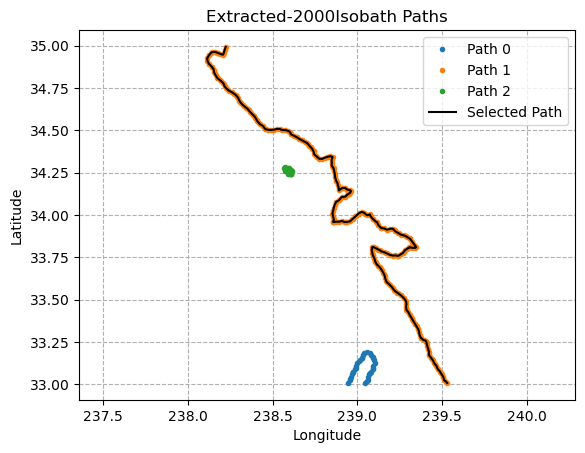

In [7]:
# Preform is ADCP data is being processed
if option_obs == 'ADCP': 

    # Use contouring to extract the 1500 m isobath(s)
    contour_set = plt.contour(lon_grid, lat_grid, bathy_grid, levels=[isobath])
    plt.close()  # Prevents plot from displaying if you're in a notebook

    # Extract all contour paths at the 1500 m level
    paths = contour_set.allsegs[0] 

    # Filter based on number of points (to exclude small closed loops like seamounts)
    min_points = 100  # Adjust based on your resolution
    valid_paths = [p for p in paths if len(p) > min_points]

    # Select the longest or first valid path (shelf break usually shows up first)
    selected_path = valid_paths[0]  # Or choose based on location

    # Extract lon/lat from the path
    lon_iso = selected_path[:, 0]
    lat_iso = selected_path[:, 1]

    # Plot the -2000 meter isobath contours and selected path
    if option_plot == True:

        # Loop through paths
        for i, p in enumerate(paths):

            # Plot the ith contour path
            plt.plot(p[:, 0], p[:, 1], '.', label=f'Path {i}')

        # Plot the selected path 
        plt.plot(lon_iso,lat_iso, 'k-', label='Selected Path')

        # Set figure attributes
        plt.axis('equal')
        plt.grid(True,linestyle='--')
        plt.legend()
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title("Extracted" + str(isobath) + "Isobath Paths")
        plt.show()

Convert the isobath coordinate to easting and northing coordinates

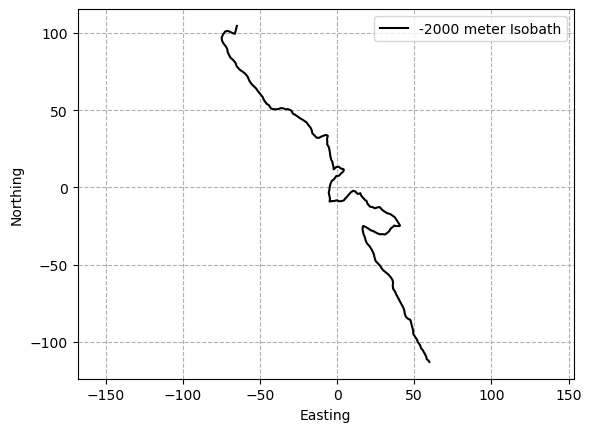

In [8]:
# Preform is ADCP data is being processed
if option_obs == 'ADCP': 
    
    # Easting and Northing projection for the region, e.g., UTM zone 10N for California
    transformer = Transformer.from_crs("epsg:4326", "epsg:32610", always_xy=True)  # WGS84 to UTM Zone 10N

    # Convert lon/lat to x/y in meters
    x_iso, y_iso = transformer.transform(lon_iso, lat_iso)

    # Adjust isobath coordinates
    x_iso_n, y_iso_n = (1/1000)* (x_iso - np.mean(x_iso)), (1/1000)* (y_iso - np.mean(y_iso)) 

    # Plot the smoothed isobath in easting and northing coordinates
    if option_plot == True:

        # Plot the unsmoothed and smoothed isobaths 
        plt.plot(x_iso_n,y_iso_n, 'k-', label= str(isobath) + ' meter Isobath')

        # Set figure attributes
        plt.axis('equal')
        plt.grid(True,linestyle='--')
        plt.legend()
        plt.xlabel("Easting")
        plt.ylabel("Northing")
        plt.show()

Calculate the Orientation Angle for the isobath and Plot the bathymetry with linear fit

305.4714208255787
125.47142082557872


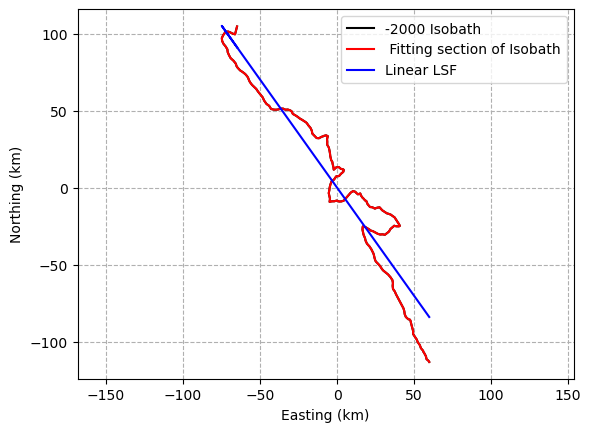

In [9]:
# Preform is ADCP data is being processed
if option_obs == 'ADCP': 

    # Set the limits of the linear fit 
    x_min, x_max = -100, 100  # -25, 20 
    y_min, y_max = -200,  200 # -25, 20

    # Mask easting and northing vectors based on limits above
    x_mask = (x_iso_n >= x_min) & (x_iso_n <= x_max) 
    y_mask = (y_iso_n >= y_min) & (y_iso_n <= y_max) 
    mask = x_mask & y_mask 

    # Apply mask
    x_iso_mask = x_iso_n[mask]
    y_iso_mask = y_iso_n[mask]

    # Fit a straight line to the bathymetry
    m, b = np.polyfit(x_iso_mask, y_iso_mask, 1)  

    # Compute the angle
    theta = np.arctan(m)  

    # Orient the angle so positive along-shelf is upcoast (northernly) and positive cross-shelf is offshore (westerly) 
    theta_n = theta - (np.pi)

    # Print the angle in units of degrees
    print(np.rad2deg(theta) % 360)
    print(np.rad2deg(theta_n) % 360)

    # Compute the linear fit line 
    bfit = m*(x_iso_mask) + b

    # Plot the isobath and linear fit 
    plt.plot(x_iso_n,y_iso_n, 'k-', label= str(isobath) + ' Isobath')
    plt.plot(x_iso_mask,y_iso_mask, 'r-', label = ' Fitting section of Isobath')
    plt.plot(x_iso_mask,bfit, 'b-', label='Linear LSF')

    # Set figure attributes
    plt.axis('equal')
    plt.grid(True,linestyle='--')
    plt.legend()
    plt.xlabel("Easting (km)")
    plt.ylabel("Northing (km)")
    plt.show()

Compute the depth averaged velocity 

In [10]:
# Preform is ADCP data is being processed
if option_obs == 'ADCP': 

    #--- Compute depth average ---# 

    # Mask depth levels deeper than 400 m
    depth_mask = depth <= 600

    # Apply mask and compute mean over axis=0 (depth)
    u_mask = ucur[depth_mask, :]
    v_mask = vcur[depth_mask, :]

    # Compute depth average (assuming evenly spaced)
    ucur_avg = np.mean(u_mask,axis=0)
    vcur_avg = np.mean(v_mask,axis=0)

    #--- Compute daily average (from depth average) ---# 

    # Convert to Python datetime if needed
    if np.issubdtype(time_hourly.dtype, np.datetime64):
        time_dt = time_hourly.astype('datetime64[s]').astype(datetime.datetime)
    else:
        time_dt = time_hourly

    # Get date only (removes hours, minutes, etc.)
    dates = np.array([t.date() for t in time_dt])

    # Find unique days and their indices
    unique_days, day_indices = np.unique(dates, return_inverse=True)

    # Initialize output arrays
    u_daily = np.zeros(len(unique_days))
    v_daily = np.zeros(len(unique_days))

    # Average u and v over each unique day
    for i in range(len(unique_days)):
        mask = (day_indices == i)
        u_daily[i] = np.mean(ucur_avg[mask])
        v_daily[i] = np.mean(vcur_avg[mask])

    # Convert to datetime64 for plotting with Matplotlib
    time_daily = np.array(unique_days, dtype='datetime64[D]')

    #--- Compute a 5 day running mean (from depth and daily average) ---# 

    # Set running mean parameters
    window_size = 5  # must be odd for centered smoothing
    kernel = np.ones(window_size) / window_size

    # COmpute running mean
    u_smooth = np.convolve(u_daily, kernel, mode='same')
    v_smooth = np.convolve(v_daily, kernel, mode='same')

    #--- Rotate the depth averaged vectors into along and cross-shelf directions

    # Rotation matrix components
    cos_a = np.cos(theta_n)
    sin_a = np.sin(theta_n)

    # Rotate velocities

    # Full depth and time dependent velocities
    u_along = ucur * cos_a + vcur * sin_a
    v_cross = -ucur * sin_a + vcur * cos_a

    # Depth avg velocities
    u_along_avg = ucur_avg * cos_a + vcur_avg * sin_a
    v_cross_avg = -ucur_avg * sin_a + vcur_avg * cos_a

    # Depth and daily avg velocities
    u_along_d = u_daily * cos_a + v_daily * sin_a
    v_cross_d = -u_daily * sin_a + v_daily * cos_a

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_51297/4294874266.py:38: UserWarning: Warning: converting a masked element to nan.
  u_daily[i] = np.mean(ucur_avg[mask])
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_51297/4294874266.py:39: UserWarning: Warning: converting a masked element to nan.
  v_daily[i] = np.mean(vcur_avg[mask])


Plot the ADCP current velocity maps

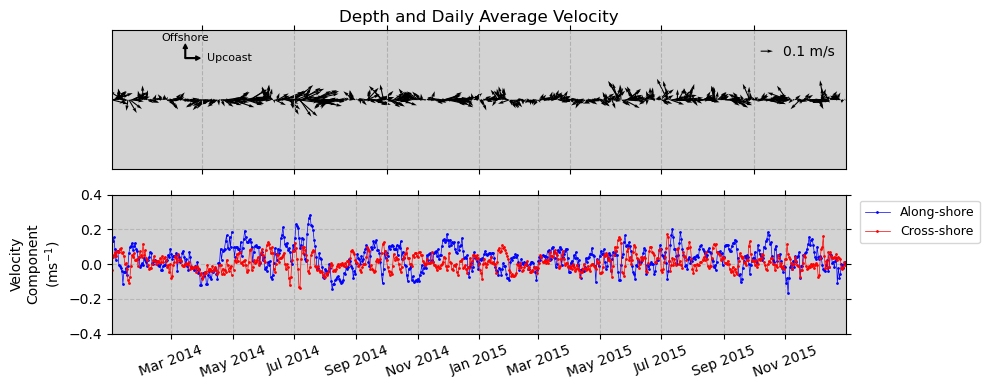

In [11]:
# Preform is ADCP data is being processed
if option_obs == 'ADCP': 

    # Create figure
    fig, axes = plt.subplots(2,1,figsize=(10, 4))
    ax1,ax2 = axes.flatten()

    #--- Subplot 1 ---# 

    # Plot the velocity vectors
    q = ax1.quiver(time_daily, np.zeros_like(time_daily), u_along_d, v_cross_d, scale=6, width=0.0015)

    # Set axis attributes
    ax1.set_title("Depth and Daily Average Velocity")
    ax1.set_xlim([time[0], time[-1]])
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.tick_params(top=True, bottom=True, left=False, right=False,
                direction='out', length=3.5)
    ax1.grid(True, linestyle='--')

    # Set quiver legend
    ax1.quiverkey(q, X=0.9, Y=0.85, U=0.1, label='0.1 m/s', labelpos='E', coordinates='axes')

    # Set the background color of the axes
    ax1.set_facecolor('lightgray')

    # Add coordinate system arrows in top subplot
    arrow_length_x,arrow_length_y = 0.02, 0.1  # adjust based on scale of your plot
    x0, y0 = 0.1, 0.8    # location in axis coordinates (0–1)

    # Add arrows using annotation in axis coordinates
    ax1.annotate('', xy=(x0 + arrow_length_x, y0), xytext=(x0, y0),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=3))
    ax1.text(x0 + arrow_length_x + 0.01, y0, 'Upcoast', transform=ax1.transAxes,
            verticalalignment='center', fontsize=8)

    ax1.annotate('', xy=(x0, y0 + arrow_length_y), xytext=(x0, y0),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=3))
    ax1.text(x0, y0 + arrow_length_y + 0.02, 'Offshore', transform=ax1.transAxes,
            horizontalalignment='center', fontsize=8)

    #--- Subplot 2 ---#  

    # Plot depth and daily average along- and cross-shore components
    ax2.plot(time_daily, u_along_d, '.-', label="Along-shore", color='blue', linewidth=0.5, markersize=2)
    ax2.plot(time_daily, v_cross_d, '.-', label="Cross-shore", color='red', linewidth=0.5, markersize=2)

    # Set legend
    ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

    # Set axis attributes
    ax2.set_ylabel("Velocity\nComponent\n(ms$^{-1}$)")
    ax2.set_xlim(time[0], time[-1])
    ax2.set_ylim([-0.4,0.4])
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=20)
    ax2.tick_params(top=True, bottom=True, left=True, right=True,
                direction='out', length=3.5)
    ax2.grid(True, linestyle='--', alpha=0.8)

    # Set the background color of the axes
    ax2.set_facecolor('lightgray')

    # Display figure
    plt.tight_layout()
    plt.show()

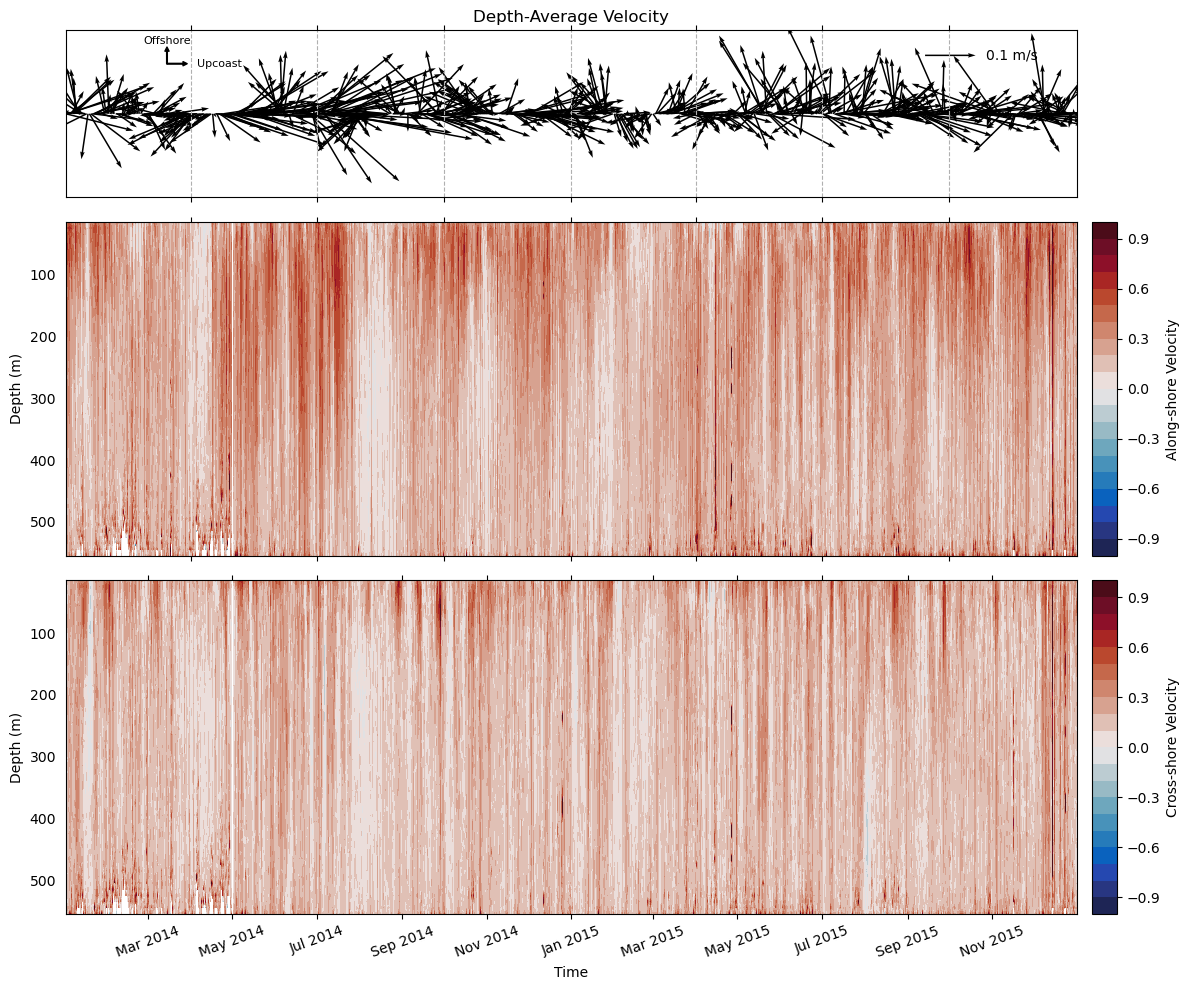

In [12]:
# Preform is ADCP data is being processed
if option_obs == 'ADCP': 

    # Set plotting paramters
    levels = np.linspace(-1, 1, 21)

    # Create figure and GridSpec with extra column for colorbars
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(nrows=3, ncols=2, width_ratios=[40, 1], height_ratios=[1, 2, 2], figure=fig)

    #--- Subplot 1 ---# 
    ax0 = fig.add_subplot(gs[0, 0])
    q = ax0.quiver(time_daily, np.zeros_like(time_daily), u_along_d, v_cross_d, scale=2, width=0.0015)
    ax0.set_title("Depth-Average Velocity")
    ax0.set_xticklabels([])
    ax0.set_yticks([])
    ax0.tick_params(top=True, bottom=True, left=False, right=False,
                direction='out', length=3.5)
    ax0.set_xlim([time[0], time[-1]])
    ax0.quiverkey(q, X=0.9, Y=0.85, U=0.1, label='0.1 m/s', labelpos='E', coordinates='axes')
    ax0.grid(True, linestyle='--')

    # Add coordinate system arrows in top subplot
    arrow_length_x,arrow_length_y = 0.02, 0.1  # adjust based on scale of your plot
    x0, y0 = 0.1, 0.8    # location in axis coordinates (0–1)

    # Add arrows using annotation in axis coordinates
    ax0.annotate('', xy=(x0 + arrow_length_x, y0), xytext=(x0, y0),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=3))
    ax0.text(x0 + arrow_length_x + 0.01, y0, 'Upcoast', transform=ax0.transAxes,
            verticalalignment='center', fontsize=8)

    ax0.annotate('', xy=(x0, y0 + arrow_length_y), xytext=(x0, y0),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=3))
    ax0.text(x0, y0 + arrow_length_y + 0.02, 'Offshore', transform=ax0.transAxes,
            horizontalalignment='center', fontsize=8)

    #--- Subplot 2 ---# 
    ax1 = fig.add_subplot(gs[1, 0])
    cf1 = ax1.contourf(time, depth, u_along, levels=levels, cmap=cmocean.cm.balance, vmin=-1, vmax=1)
    ax1.set_ylabel("Depth (m)")
    ax1.set_xticklabels([])
    ax1.tick_params(top=True, bottom=True, left=False, right=False,
                direction='out', length=3.5)
    ax1.invert_yaxis()

    # Add colorbar
    cax1 = fig.add_subplot(gs[1, 1])  # colorbar axis in second column
    fig.colorbar(cf1, cax=cax1, label='Along-shore Velocity')

    #--- Subplot 3 ---# 
    ax2 = fig.add_subplot(gs[2, 0])
    cf2 = ax2.contourf(time, depth, v_cross, levels=levels, cmap=cmocean.cm.balance, vmin=-1, vmax=1)
    ax2.set_ylabel("Depth (m)")
    ax2.set_xlabel("Time")
    ax2.tick_params(top=True, bottom=True, left=False, right=False,
                direction='out', length=3.5)
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=20)
    ax2.invert_yaxis()
    

    # Add colorbar
    cax2 = fig.add_subplot(gs[2, 1])
    fig.colorbar(cf2, cax=cax2, label='Cross-shore Velocity')

    # Show figure
    plt.tight_layout()
    plt.show()

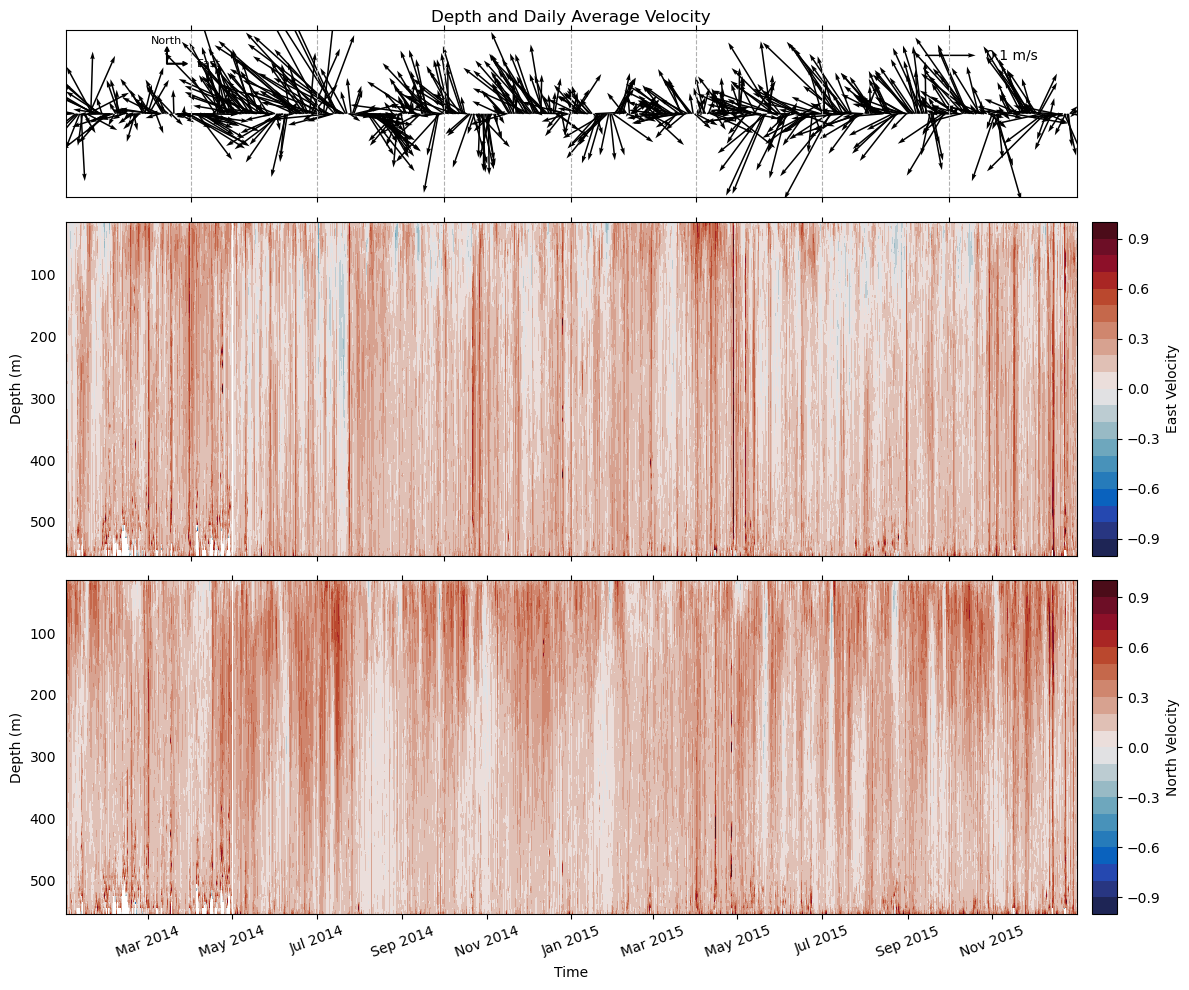

In [13]:
# Preform is ADCP data is being processed
if option_obs == 'ADCP': 

    # Set plotting paramters
    levels = np.linspace(-1, 1, 21)

    # Create figure and GridSpec with extra column for colorbars
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(nrows=3, ncols=2, width_ratios=[40, 1], height_ratios=[1, 2, 2], figure=fig)

    #--- Subplot 1 ---# 
    ax0 = fig.add_subplot(gs[0, 0])
    q = ax0.quiver(time_daily, np.zeros_like(time_daily), u_daily, v_daily, scale=2, width=0.0015)
    ax0.set_title("Depth and Daily Average Velocity")
    ax0.set_xticklabels([])
    ax0.set_yticks([])
    ax0.tick_params(top=True, bottom=True, left=False, right=False,
                direction='out', length=3.5)
    ax0.set_xlim([time[0], time[-1]])
    ax0.quiverkey(q, X=0.9, Y=0.85, U=0.1, label='0.1 m/s', labelpos='E', coordinates='axes')
    ax0.grid(True, linestyle='--')

    # Add coordinate system arrows in top subplot
    arrow_length_x,arrow_length_y = 0.02, 0.1  # adjust based on scale of your plot
    x0, y0 = 0.1, 0.8    # location in axis coordinates (0–1)

    # Add arrows using annotation in axis coordinates
    ax0.annotate('', xy=(x0 + arrow_length_x, y0), xytext=(x0, y0),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=3))
    ax0.text(x0 + arrow_length_x + 0.01, y0, 'East', transform=ax0.transAxes,
            verticalalignment='center', fontsize=8)

    ax0.annotate('', xy=(x0, y0 + arrow_length_y), xytext=(x0, y0),
                xycoords='axes fraction', textcoords='axes fraction',
                arrowprops=dict(facecolor='black', width=0.5, headwidth=3, headlength=3))
    ax0.text(x0, y0 + arrow_length_y + 0.02, 'North', transform=ax0.transAxes,
            horizontalalignment='center', fontsize=8)

    #--- Subplot 2 ---# 
    ax1 = fig.add_subplot(gs[1, 0])
    cf1 = ax1.contourf(time, depth, ucur, levels=levels, cmap=cmocean.cm.balance, vmin=-1, vmax=1)
    ax1.set_ylabel("Depth (m)")
    ax1.set_xticklabels([])
    ax1.tick_params(top=True, bottom=True, left=False, right=False,
                direction='out', length=3.5)
    ax1.invert_yaxis()

    # Add colorbar
    cax1 = fig.add_subplot(gs[1, 1])  # colorbar axis in second column
    fig.colorbar(cf1, cax=cax1, label='East Velocity')

    #--- Subplot 3 ---# 
    ax2 = fig.add_subplot(gs[2, 0])
    cf2 = ax2.contourf(time, depth, vcur, levels=levels, cmap=cmocean.cm.balance, vmin=-1, vmax=1)
    ax2.set_ylabel("Depth (m)")
    ax2.set_xlabel("Time")
    ax2.tick_params(top=True, bottom=True, left=False, right=False,
                direction='out', length=3.5)
    ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax2.get_xticklabels(), rotation=20)
    ax2.invert_yaxis()

    # Add colorbar
    cax2 = fig.add_subplot(gs[2, 1])
    fig.colorbar(cf2, cax=cax2, label='North Velocity')

    # Show figure
    plt.tight_layout()
    plt.show()

Plot the presure, temperature, and salinity time series

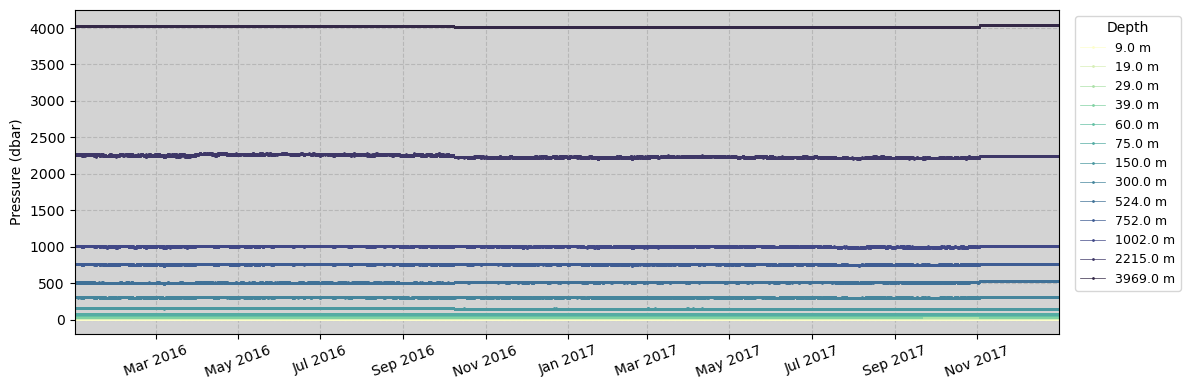

In [ ]:
# Preform is CTD data is being processed
if option_obs == 'CTD': 

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 4))

    # Set colormap fro depths
    cmap = cmocean.cm.deep
    colors = [cmap(i / len(depth)) for i in range(len(depth))]

    # Plot each depth
    for i, idepth in enumerate(depth):
        ax.plot(time, pres[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

    # Set legend
    ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

    # Set axis attributes
    ax.set_ylabel(r"Pressure (dbar)")
    ax.set_xlim(time[0], time[-1])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.get_xticklabels(), rotation=20)
    ax.grid(True, linestyle='--', alpha=0.8)

    # Set the background color of the axes
    ax.set_facecolor('lightgray')

    # Display figure
    plt.tight_layout()
    plt.show()

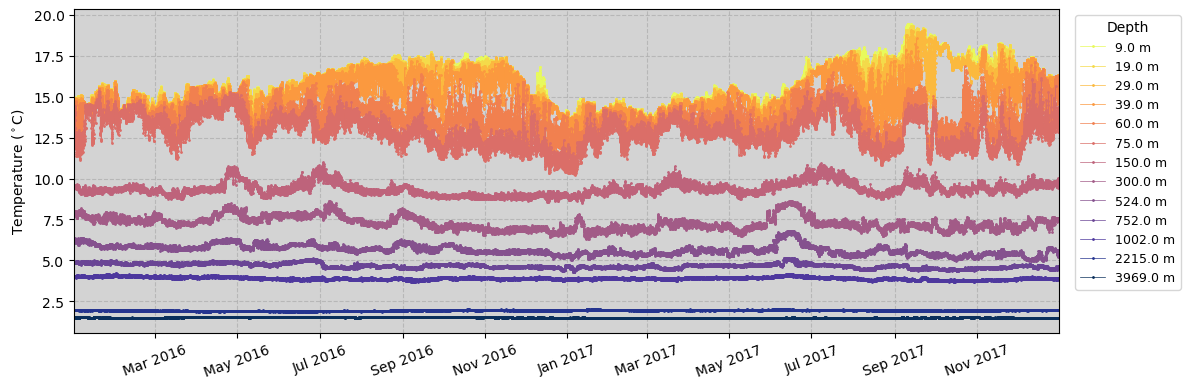

In [ ]:
# Preform is CTD data is being processed
if option_obs == 'CTD': 

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 4))

    # Set colormap fro depths
    cmap = cmocean.cm.thermal.reversed()
    colors = [cmap(i / len(depth)) for i in range(len(depth))]

    # Plot each depth
    for i, idepth in enumerate(depth):
        ax.plot(time, temp[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

    # Set legend
    ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

    # Set axis attributes
    ax.set_ylabel(r"Temperature ($^\circ$C)")
    ax.set_xlim(time[0], time[-1])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.get_xticklabels(), rotation=20)
    ax.grid(True, linestyle='--', alpha=0.8)

    # Set the background color of the axes
    ax.set_facecolor('lightgray')

    # Display figure
    plt.tight_layout()
    plt.show()

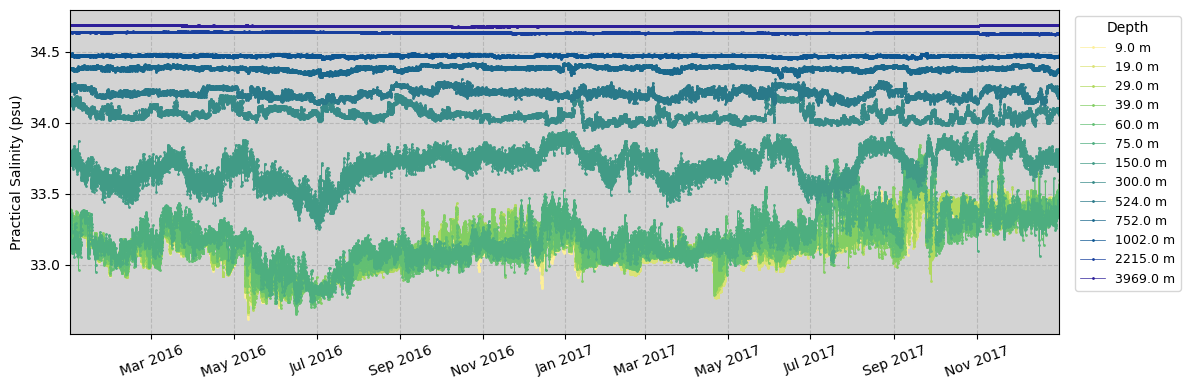

In [ ]:
# Preform is CTD data is being processed
if option_obs == 'CTD': 

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 4))

    # Set colormap from depths
    cmap = cmocean.cm.haline.reversed()
    colors = [cmap(i / len(depth)) for i in range(len(depth))]

    # Plot each depth
    for i, idepth in enumerate(depth):
        ax.plot(time, sal[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

    # Set legend
    ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

    # Set axis attributes
    ax.set_ylabel(r"Practical Salinity (psu)")
    ax.set_xlim(time[0], time[-1])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.get_xticklabels(), rotation=20)
    ax.grid(True, linestyle='--', alpha=0.8)

    # Set the background color of the axes
    ax.set_facecolor('lightgray')

    # Display figure
    plt.tight_layout()
    plt.show()

Compute potential density at several reference levels

In [ ]:
# Preform is CTD data is being processed
if option_obs == 'CTD': 

    # Set dimnesions
    ndepth,ntime = np.shape(temp)

    # Convert depths to the coordinate system with positive z up 
    depth_conv = -1 * depth  # Units: m

    # Initialize an array for the pressure, conservative temperature, absolute salinity, and in-situ/potential density 
    pressure = np.zeros_like(temp)
    CT       = np.zeros_like(temp)
    SA       = np.zeros_like(temp)
    density  = np.zeros_like(temp)
    sigma0   = np.zeros_like(temp)
    sigma1   = np.zeros_like(temp)
    sigma2   = np.zeros_like(temp)
    sigma3   = np.zeros_like(temp)

    # Loop through time steps 
    for idata in range(0,ntime):

        # Compute absolute salinity 
        SA[:,idata] = gsw.conversions.SA_from_SP(sal[:,idata], pres[:,idata], lon[0], lat[0]) # Units: g/kg

        # Compute Conservative temperature from absolute salinity, in-situ temperature and pressure
        CT[:,idata] = gsw.conversions.CT_from_t(SA[:,idata], temp[:,idata], pres[:,idata])  # Units: degrees Celcius

        # Compute in-situ and potential density (with reference pressure of 0 dbar) 
        density[:,idata] = gsw.density.rho(SA[:,idata],CT[:,idata],pres[:,idata])  # Units: kg/m^3
        sigma0[:,idata] = gsw.density.sigma0(SA[:,idata], CT[:,idata])  # Units: kg/m^3
        sigma1[:,idata] = gsw.density.sigma1(SA[:,idata], CT[:,idata])  # Units: kg/m^3
        sigma2[:,idata] = gsw.density.sigma2(SA[:,idata], CT[:,idata])  # Units: kg/m^3
        sigma3[:,idata] = gsw.density.sigma0(SA[:,idata], CT[:,idata])  # Units: kg/m^3

Plot conservative temperature, absolute salinity, and potential density 

In [21]:
# Preform is CTD data is being processed
if option_obs == 'CTD': 

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 4))

    # Set colormap fro depths
    cmap = cmocean.cm.thermal.reversed()
    colors = [cmap(i / len(depth)) for i in range(len(depth))]

    # Plot each depth
    for i, idepth in enumerate(depth):
        ax.plot(time, CT[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

    # Set legend
    ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

    # Set axis attributes
    ax.set_ylabel(r"Temperature ($^\circ$C)")
    ax.set_xlim(time[0], time[-1])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.get_xticklabels(), rotation=20)
    ax.grid(True, linestyle='--', alpha=0.8)

    # Set the background color of the axes
    ax.set_facecolor('lightgray')

    # Display figure
    plt.tight_layout()
    plt.show()

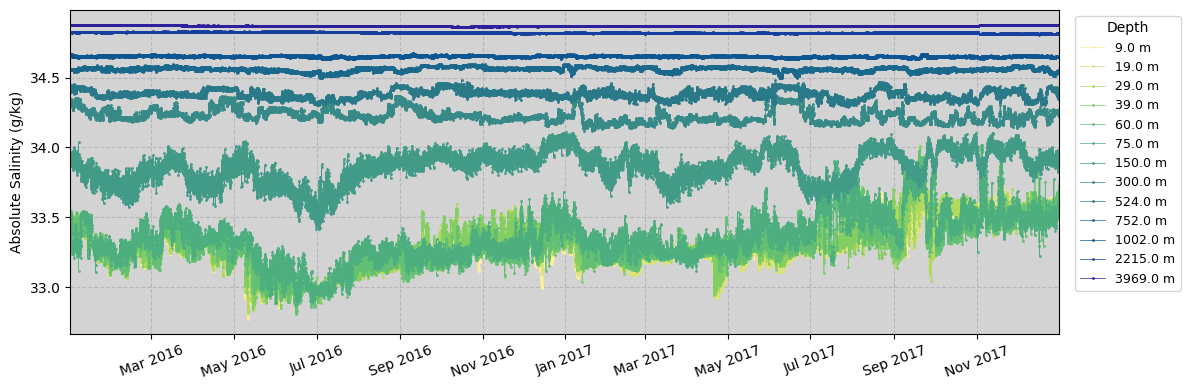

In [ ]:
# Preform is CTD data is being processed
if option_obs == 'CTD': 

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 4))

    # Set colormap from depths
    cmap = cmocean.cm.haline.reversed()
    colors = [cmap(i / len(depth)) for i in range(len(depth))]

    # Plot each depth
    for i, idepth in enumerate(depth):
        ax.plot(time, SA[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

    # Set legend
    ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

    # Set axis attributes
    ax.set_ylabel(r"Absolute Salinity (g/kg)")
    ax.set_xlim(time[0], time[-1])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.get_xticklabels(), rotation=20)
    ax.grid(True, linestyle='--', alpha=0.8)

    # Set the background color of the axes
    ax.set_facecolor('lightgray')

    # Display figure
    plt.tight_layout()
    plt.show()

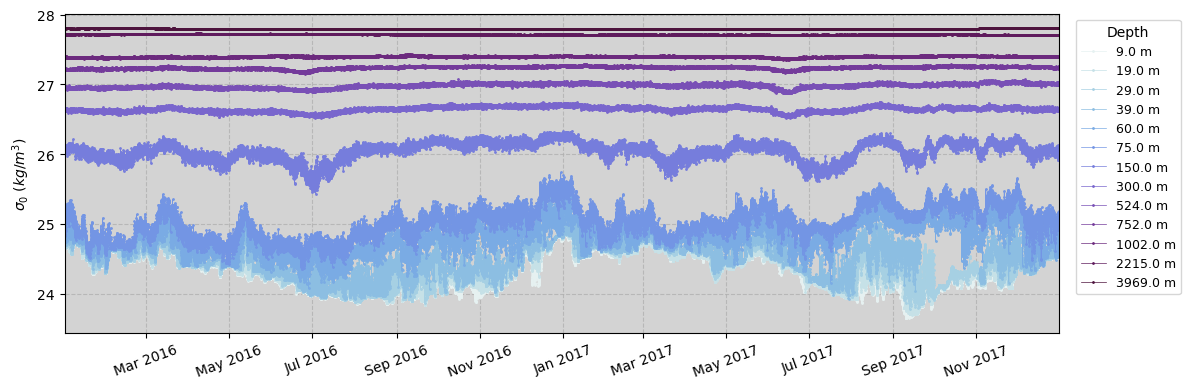

In [ ]:
# Preform is CTD data is being processed
if option_obs == 'CTD': 

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 4))

    # Set colormap fro depths
    cmap = cmocean.cm.dense
    colors = [cmap(i / len(depth)) for i in range(len(depth))]

    # Plot each depth
    for i, idepth in enumerate(depth):
        ax.plot(time, sigma0[i,:], '.-', label=f"{idepth} m", color=colors[i], linewidth=0.5, markersize=2)

    # Set legend
    ax.legend(title="Depth", bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=9)

    # Set axis attributes
    ax.set_ylabel(r"$\sigma_0$ ($kg/m^3$)")
    ax.set_xlim(time[0], time[-1])
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.setp(ax.get_xticklabels(), rotation=20)
    ax.grid(True, linestyle='--', alpha=0.8)

    # Set the background color of the axes
    ax.set_facecolor('lightgray')

    # Display figure
    plt.tight_layout()
    plt.show()

Save intermediate data in a netCDF for future use

In [14]:
# Preform is CTD data is being processed
if option_obs == 'CTD': 

    #--- Sea State Varibles ---# 
    Pressure = xr.DataArray(data=pres, 
                        dims=['depth','time',],
                        coords=dict(depth=depth,time=time),
                        attrs=dict(
                            description='Pressure profiles time series.',
                            units='dbar'
                            )
    )

    Density = xr.DataArray(data=density, 
                        dims=['depth','time',],
                        coords=dict(depth=depth,time=time),
                        attrs=dict(
                            description='In-situ Density profiles time series.',
                            units='kg/m^3'
                            )
    ) 

    SIG0 = xr.DataArray(data=sigma0, 
                        dims=['depth','time',],
                        coords=dict(depth=depth,time=time),
                        attrs=dict(
                            description='Potential Density anomaly profiles referenced to the pressure at the sea surface.',
                            units='kg/m^3'
                            )
    ) 

    SIG1 = xr.DataArray(data=sigma1, 
                        dims=['depth','time',],
                        coords=dict(depth=depth,time=time),
                        attrs=dict(
                            description='Potential Density anomaly profiles referenced to the pressure at 1000 meters.',
                            units='kg/m^3'
                            )
    ) 

    SIG2 = xr.DataArray(data=sigma2, 
                        dims=['depth','time',],
                        coords=dict(depth=depth,time=time),
                        attrs=dict(
                            description='Potential Density anomaly profiles referenced to the pressure at 2000 meters.',
                            units='kg/m^3'
                            )
    ) 

    SIG3 = xr.DataArray(data=sigma3, 
                        dims=['depth','time',],
                        coords=dict(depth=depth,time=time),
                        attrs=dict(
                            description='Potential Density anomaly profiles referenced to the pressure at 3000 meters.',
                            units='kg/m^3'
                            )
    ) 

    CTemp = xr.DataArray(data=CT, 
                        dims=['depth','time',],
                        coords=dict(depth=depth,time=time),
                        attrs=dict(
                            description='Conservative temperature profiles time series.',
                            units='degrees Celcius'
                            )
    ) 

    ASal = xr.DataArray(data=SA, 
                        dims=['depth','time',],
                        coords=dict(depth=depth,time=time),
                        attrs=dict(
                            description='Absolute Salinity profiles time series.',
                            units='g/kg'
                            )
    ) 

    #--- Latitude and Longitude Coordinates ---# 
    LON = xr.DataArray(data=lon, 
                        dims=['lon'],
                        coords=dict(lon=lon),
                        attrs=dict(
                            description='Longitude of the mooring.'
                            )
    ) 

    LAT = xr.DataArray(data=lat, 
                        dims=['lat'],
                        coords=dict(lat=lat),
                        attrs=dict(
                            description='Latitude of mooring.'
                            )
    ) 

    TIME = xr.DataArray(data=time, 
                        dims=['time'],
                        coords=dict(time=time),
                        attrs=dict(
                            description='Time (in datetime formation) for mooring time series.'
                            )
    ) 

    # Create a data set from data arrays 
    data = xr.Dataset({'Pressure':Pressure,'Density':Density,'SIG0':SIG0,'SIG1':SIG1,'SIG2':SIG2,'SIG3':SIG3,'CTemp':CTemp,'ASal':ASal,'LON':LON,'LAT':LAT,'TIME':TIME})

    # Check if file exists, then delete it
    file_path = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_data.nc"
    if os.path.exists(file_path):
        os.remove(file_path)

    # Create netcdf file
    data.to_netcdf(file_path,mode='w')


# Preform is ADCP data is being processed
if option_obs == 'ADCP': 

    #--- Easting-Northing Coordinates ---# 
    U = xr.DataArray(data=ucur, 
                     dims=['depth','time',],
                     coords=dict(depth=depth,time=time),
                     attrs=dict(
                            description='Hourly upper-ocean zonal velocity component.',
                            units='m/s'
                            )
    )

    V = xr.DataArray(data=vcur, 
                     dims=['depth','time',],
                     coords=dict(depth=depth,time=time),
                     attrs=dict(
                            description='Hourly upper-ocean meridional velocity component.',
                            units='m/s'
                            )
    ) 

    U_depth = xr.DataArray(data=ucur_avg, 
                           dims=['time',],
                           coords=dict(time=time),
                           attrs=dict(
                            description='Depth-averaged hourly zonal velocity component.',
                            units='m/s'
                            )
    ) 

    V_depth = xr.DataArray(data=vcur_avg, 
                           dims=['time',],
                           coords=dict(time=time),
                           attrs=dict(
                            description='Depth-averaged hourly meridional velocity component.',
                            units='m/s'
                            )
    ) 

    U_daily = xr.DataArray(data=u_daily, 
                        dims=['time_daily',],
                        coords=dict(time_daily=time_daily),
                        attrs=dict(
                            description='Depth and daily averaged zonal velocity component.',
                            units='m/s'
                            )
    ) 

    V_daily = xr.DataArray(data=v_daily, 
                        dims=['time_daily',],
                        coords=dict(time_daily=time_daily),
                        attrs=dict(
                            description='Depth and daily averaged meridional velocity component.',
                            units='m/s'
                            )
    ) 

    #--- Cross-Along Shelf Coordinates ---# 

    U_shelf = xr.DataArray(data=u_along, 
                     dims=['depth','time',],
                     coords=dict(depth=depth,time=time),
                     attrs=dict(
                            description='Hourly upper-ocean along-shelf ' + str(isobath) +  ' isobath velocity component.',
                            units='m/s'
                            )
    )

    V_shelf = xr.DataArray(data=v_cross, 
                     dims=['depth','time',],
                     coords=dict(depth=depth,time=time),
                     attrs=dict(
                            description='Hourly upper-ocean cross-shelf ' + str(isobath) +  ' isobath velocity component.',
                            units='m/s'
                            )
    ) 

    U_shelf_depth = xr.DataArray(data=u_along_avg, 
                           dims=['time',],
                           coords=dict(time=time),
                           attrs=dict(
                            description='Depth-averaged hourly along-shelf ' + str(isobath) +  ' isobath velocity component.',
                            units='m/s'
                            )
    ) 

    V_shelf_depth = xr.DataArray(data=v_cross_avg, 
                           dims=['time',],
                           coords=dict(time=time),
                           attrs=dict(
                            description='Depth-averaged hourly cross-shelf ' + str(isobath) +  ' isobath velocity component.',
                            units='m/s'
                            )
    ) 

    U_shelf_daily = xr.DataArray(data=u_along_d, 
                        dims=['time_daily',],
                        coords=dict(time_daily=time_daily),
                        attrs=dict(
                            description='Depth and daily averaged along-shelf ' + str(isobath) +  ' isobath velocity component.',
                            units='m/s'
                            )
    ) 

    V_shelf_daily = xr.DataArray(data=v_cross_d, 
                        dims=['time_daily',],
                        coords=dict(time_daily=time_daily),
                        attrs=dict(
                            description='Depth and daily averaged cross-shelf ' + str(isobath) +  ' isobath velocity component.',
                            units='m/s'
                            )
    ) 

    #--- Latitude and Longitude Coordinates ---# 
    LON = xr.DataArray(data=lon, 
                        dims=['lon'],
                        coords=dict(lon=lon),
                        attrs=dict(
                            description='Longitude of the mooring.'
                            )
    ) 

    LAT = xr.DataArray(data=lat, 
                        dims=['lat'],
                        coords=dict(lat=lat),
                        attrs=dict(
                            description='Latitude of mooring.'
                            )
    ) 

    # Create a data set from data arrays 
    data = xr.Dataset({'U':U,'V':V,'U_depth':U_depth,'V_depth':V_depth,'U_daily':U_daily,'V_daily':V_daily,'U_shelf':U_shelf,'V_shelf':V_shelf,'U_shelf_depth':U_shelf_depth,'V_shelf_depth':V_shelf_depth,'U_shelf_daily':U_shelf_daily,'V_shelf_daily':V_shelf_daily,'LON':LON,'LAT':LAT})

    # Check if file exists, then delete it
    file_path = PATH + "/data/CCE/" + option_mooring + "/" + option_obs + "/" + option_mooring + "_" + option_obs + "_" + str(start_time.year) + str(start_time.month) + str(start_time.day) +  "-" + str(end_time.year) + str(end_time.month) + str(end_time.day) + "_intermediate_data.nc"
    if os.path.exists(file_path):
        os.remove(file_path)

    # Create netcdf file
    data.to_netcdf(file_path,mode='w')

/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_51297/2841496332.py:154: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  U_daily = xr.DataArray(data=u_daily,
/var/folders/2q/rg93ky5n09l14670ynhs0cgh0000gn/T/ipykernel_51297/2841496332.py:163: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the Dat

In [47]:
data

<xarray.Dataset> Size: 16MB
Dimensions:        (depth: 55, time: 8760, time_daily: 365, lon: 1, lat: 1)
Coordinates:
  * depth          (depth) float64 440B 14.7 24.7 34.7 ... 534.7 544.7 554.7
  * time           (time) datetime64[ns] 70kB 2015-01-01T00:30:00 ... 2015-12...
  * time_daily     (time_daily) datetime64[ns] 3kB 2015-01-01 ... 2015-12-31
  * lon            (lon) float64 8B -122.5
  * lat            (lat) float64 8B 33.45
Data variables: (12/14)
    U              (depth, time) float64 4MB 0.04757 -0.04743 ... -0.08609
    V              (depth, time) float64 4MB -0.1088 -0.02819 ... 0.04098
    U_depth        (time) float64 70kB -0.06555 0.03131 ... -0.02997 0.02717
    V_depth        (time) float64 70kB -0.08801 -0.2024 ... -0.06468 0.002194
    U_daily        (time_daily) float64 3kB -0.02132 -0.02009 ... -0.03389
    V_daily        (time_daily) float64 3kB 0.01813 0.02984 ... 0.006879
    ...             ...
    U_shelf_depth  (time) float64 70kB 0.03364 0.183 -0.1551 ... 0.03528 0.01398
    V_shelf_depth  (time) float64 70kB -0.1045 -0.09193 ... -0.06194 0.0234
    U_shelf_daily  (time_daily) float64 3kB -0.02714 -0.03596 ... -0.02527
    V_shelf_daily  (time_daily) float64 3kB -0.006839 0.000954 ... -0.0236
    LON            (lon) float64 8B -122.5
    LAT            (lat) float64 8B 33.45

In [ ]:
# If you need to check the metadata on a variable
# var = nc.variables['TEMP_QC'] 
# for attr in var.ncattrs():
#     print(f"{attr} : {var.getncattr(attr)}")

# print("Mean v_smooth:", np.mean(v_smooth))
# print("Any negative values?", np.any(v_smooth < 0))

# print("Mean vcur:", np.mean(vcur))
# print("Any negative values?", np.any(vcur < 0))

# ax.plot(time_daily, u_daily, '.-', label="Along-shore", color='blue', linewidth=0.5, markersize=2)
# ax.plot(time_daily, v_daily, '.-', label="Cross-shore", color='red', linewidth=0.5, markersize=2)

# ax.plot(time, u_along_avg, '.-', label="Along-shore", color='blue', linewidth=0.5, markersize=2, alpha = 0.2)
# ax.plot(time, v_cross_avg, '.-', label="Cross-shore", color='red', linewidth=0.5, markersize=2, alpha = 0.2)

long_name : quality control flag
standard_name : sea_water_temperature status_flag
valid_min : 0.0
valid_max : 9.0
flag_values : [0. 1. 2. 3. 4. 7. 8. 9.]
flag_meanings : unknown good_data probably_good_data potentially_correctable_bad_data bad_data nominal_value interpolated_value missing_value
_FillValue : -128.0


In [17]:
np.mean(u_along_avg)

0.06321841368314787

In [18]:
np.mean(v_cross_avg)


0.03733935676217819

In [19]:
np.shape(U)

(5, 17520)